In [1]:
from functools import partial

In [2]:

import pandas as pd
import numpy as np
import spacy

import shap

2023-01-06 05:53:34.541243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 05:53:52.587561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-06 05:53:52.587727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-06 05:53:52.587740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
import pyarrow

In [4]:
pyarrow.__version__

'7.0.0'

In [5]:

import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import logging
from transformers import TrainingArguments, Trainer

from transformers import RobertaForSequenceClassification, BertForSequenceClassification


In [6]:
from datasets import load_dataset
from datasets import Value, ClassLabel, Features, DatasetDict
from datasets import load_metric
import evaluate

In [7]:
from omegaconf import DictConfig, OmegaConf
import hydra

In [8]:
from preprocessing.cleaning_utils import *
from train_utils.metrics import *
from train_utils.plot_utils import *
from train_utils.custom_trainer import *


# Load in Models

In [9]:
base_model_path = "/home/vs428/project/models/RoBERTa-large-PM-M3-Voc/RoBERTa-large-PM-M3-Voc-hf"
model_path = "/home/vs428/project/n2c2_models/roberta_large_ner_so/roberta_large_ner_so/outputs/roberta_large/checkpoint-384/"
# model_path = "/home/vs428/project/n2c2_models/roberta_large_raw/outputs/roberta_large/checkpoint-867"

In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained(base_model_path,)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
tokenizer

PreTrainedTokenizerFast(name_or_path='/home/vs428/project/models/RoBERTa-large-PM-M3-Voc/RoBERTa-large-PM-M3-Voc-hf', vocab_size=50000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [12]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4).cuda()

# Read in Dev Data

In [13]:
data_path = "/home/vs428/project/n2c2/2022/Data/dev_so.csv"
spacy_assessment = "/home/vs428/project/n2c2_spacy_models/assessment_model_v2/model-best"
spacy_plan = "/home/vs428/project/n2c2_spacy_models/plan_subsection_model_v3/model-best"
spacy_so = "/home/vs428/project/n2c2_spacy_models/so_model/model-best"


In [14]:
dev = pd.read_csv(data_path)

In [15]:
dev

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation,HADM_ID,S,O
0,576487,112508,A 60 year old woman with recurrent ALL with CN...,"CNS VRE: S/P Omaya removal, on linezolid for ...",Direct,112508,NGT placed/TF started Femoral line changed o...,Last dose of Antibiotics: Meropenem - [**2176...
1,576487,112508,A 60 year old woman with recurrent ALL with CN...,LEUKOCYTOSIS: GCSF vs culture negative bacte...,Direct,112508,NGT placed/TF started Femoral line changed o...,Last dose of Antibiotics: Meropenem - [**2176...
2,576487,112508,A 60 year old woman with recurrent ALL with CN...,ALL: Currently day +43 s/p hyper-CVAD. She i...,Indirect,112508,NGT placed/TF started Femoral line changed o...,Last dose of Antibiotics: Meropenem - [**2176...
3,576487,112508,A 60 year old woman with recurrent ALL with CN...,DRUG RASH: Appears improved today. Evidence ...,Indirect,112508,NGT placed/TF started Femoral line changed o...,Last dose of Antibiotics: Meropenem - [**2176...
4,576487,112508,A 60 year old woman with recurrent ALL with CN...,ELEVATED LIVER ENZYMES: Consistent with shock...,Neither,112508,NGT placed/TF started Femoral line changed o...,Last dose of Antibiotics: Meropenem - [**2176...
...,...,...,...,...,...,...,...,...
592,679058,187377,"This is a 67 year old male h/o HTN, systolic H...",# Hct Drop: Likely represents GI bleed though ...,Neither,187377,Chest Pain/Multivessel CAD [**4-4**] CP at [*...,Last dose of Antibiotics: Infusions: Nitrogl...
593,679058,187377,"This is a 67 year old male h/o HTN, systolic H...",# HTN: BP well controlled at this time. Trying...,Indirect,187377,Chest Pain/Multivessel CAD [**4-4**] CP at [*...,Last dose of Antibiotics: Infusions: Nitrogl...
594,679058,187377,"This is a 67 year old male h/o HTN, systolic H...",# Hyperlipdemia: cont statin,Neither,187377,Chest Pain/Multivessel CAD [**4-4**] CP at [*...,Last dose of Antibiotics: Infusions: Nitrogl...
595,679058,187377,"This is a 67 year old male h/o HTN, systolic H...",# Tobacco Abuse: Deferrred nicotine patch at t...,Neither,187377,Chest Pain/Multivessel CAD [**4-4**] CP at [*...,Last dose of Antibiotics: Infusions: Nitrogl...


In [16]:

# create hf Dataset
classes = ['Not Relevant', 'Neither', 'Indirect', 'Direct']

# instead we will use the raw text for now
features = Features({
    'ROW ID':Value("int64"),
    'HADM ID':Value("int64"),
    'Assessment':Value("string"),
    'Plan Subsection':Value("string"),
    "Relation":Value("string"),
    "S":Value("string"),
    "O":Value("string")        

}) 

dataset = load_dataset("csv", data_files={
                            # "train":cfg.data.n2c2_data_dir + "train_so.csv",
                            "valid":data_path,
                            # "train":cfg.data.n2c2_data_dir + "train.csv",
                            # "valid":cfg.data.n2c2_data_dir + "dev.csv",

                        },
                       features=features)

# create encoded class labels and rename
label2id = {'Not Relevant':3, 'Neither':2, 'Indirect':1, 'Direct':0}
id2label = {v:k for k,v in label2id.items()}

dataset = dataset.class_encode_column("Relation")
dataset = dataset.align_labels_with_mapping(label2id, "Relation")
dataset = dataset.rename_column("Relation", "label")

# dataset['valid'] = dataset['valid'].shard(num_shards=20, index=0)

dataset = dataset.map(partial(add_SO_sections))
print("AFTER TRAIN _SO sections")
print(dataset['valid'][0])

spacy.require_gpu()
nlp_assessment = spacy.load(spacy_assessment, exclude="parser")
nlp_plan = spacy.load(spacy_plan, exclude="parser")

dataset['valid'] = dataset['valid'].map(partial(add_ner_assessment, nlp=nlp_assessment))
dataset['valid'] = dataset['valid'].map(partial(add_ner_plan, nlp=nlp_plan))        

# we ASSUME that the ner labels we want are lowercase, UNLIKE the standard ones in the model
spans = [x for x in nlp_plan.get_pipe("ner").labels if x.islower()] + [x for x in nlp_assessment.get_pipe("ner").labels if x.islower()]

tokens = []
for span in spans:
    tokens.append("<" + span + ">")
    tokens.append("</" + span + ">")            

# add the span tags to the vocab
_ = tokenizer.add_tokens(tokens)

Using custom data configuration default-86e8ba7bd129054c
Found cached dataset csv (/home/vs428/.cache/huggingface/datasets/csv/default-86e8ba7bd129054c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/vs428/.cache/huggingface/datasets/csv/default-86e8ba7bd129054c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e3d1802179efc530.arrow
Loading cached processed dataset at /home/vs428/.cache/huggingface/datasets/csv/default-86e8ba7bd129054c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0c3ea877a77644f2.arrow
Loading cached processed dataset at /home/vs428/.cache/huggingface/datasets/csv/default-86e8ba7bd129054c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-6854e1c5b4b0ed73.arrow
[W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate


AFTER TRAIN _SO sections
{'ROW ID': 576487, 'HADM ID': 112508, 'Assessment': 'A 60 year old woman with recurrent ALL with CNS involvement s/p Omaya\n   removal due to VRE contamination & SDH evacuation.  She is now doing\n   well and awake s/p extubation, afebrile and her WBC count is trending\n   downward.', 'Plan Subsection': 'CNS VRE:  S/P Omaya removal, on linezolid for greater CNS penetration\n   despite risk of CNS penetration. No TEE performed.\n   - continue linezolid (D1=[**4-16**]), course to be determined by TEE (4 vs 8\n   weeks) gentamicin D/C\nd per ID\n   - f/u culture data and sensitivities\n   - TEE deferred at this time.\n   - f/u tigacycline sensitivities for long-term therapy</s>NGT placed/TF started  Femoral line changed over wire by IR  c diff x 2 negative, 3rd pending  d/c\'ed gentamicin per ID Sulfa (Sulfonamides)  Rash;  Penicillins  Rash;  Latex  Hives; Wheezing  Red Dye  Headache; "thra  Darvon (Oral) (Propoxyphene Hcl)  Nausea/Vomiting  Percodan (Oral) (Oxyc

  0%|          | 0/597 [00:00<?, ?ex/s]

  0%|          | 0/597 [00:00<?, ?ex/s]

In [17]:
# tokked = [str(tokenizer.decode(tok_func(x,y)['input_ids']))  for x,y in zip(dataset['valid']['Assessment'], dataset['valid']['Plan Subsection'])]
tokked = [x + "\n\n<\s><\s>" + y  for x,y in zip(dataset['valid']['Assessment'], dataset['valid']['Plan Subsection'])]

In [18]:
from transformers import TextClassificationPipeline

class MyPipeline(TextClassificationPipeline):
    def preprocess(self, inputs, truncation="only_second",max_length=512, **tokenizer_kwargs):
        '''inputs here is only one example!!
        '''
        return_tensors = self.framework
        return self.tokenizer(inputs, return_tensors=return_tensors,
                              truncation=True,
                              max_length=512,
                              **tokenizer_kwargs)


In [27]:
pred = MyPipeline(model=model, tokenizer=tokenizer, device=0, 
                             top_k=None,
                 # return_all_scores=True
                 )
# pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, 
#                              return_all_scores=True)

In [28]:
pmodel = shap.models.TransformersPipeline(pred, rescale_to_logits=False)

In [29]:
labels = sorted(model.config.label2id, key=model.config.label2id.get)

In [30]:
masker = shap.maskers.Text(pred.tokenizer)

In [31]:
explainer = shap.Explainer(pmodel, masker, output_names=labels)

In [32]:
print(label2id), print(model.config.label2id)

{'Not Relevant': 3, 'Neither': 2, 'Indirect': 1, 'Direct': 0}
{'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3}


(None, None)

In [33]:
preds = pred(tokked)

In [34]:
y_preds = [int(max(pred, key=lambda x: x['score'])['label'][-1]) for pred in preds]

In [35]:
pred_df = pd.DataFrame(dataset['valid']['label'], columns=["y_true"])
pred_df['y_pred'] = y_preds
pred_df['text'] = tokked

In [36]:
scores_lst = []
for pred in preds:
    scores = {}
    for score in pred:
        scores[id2label[model.config.label2id[score['label']]]] = score['score']
    scores_lst.append(scores)

In [37]:
pred_df = pd.concat([pred_df, pd.DataFrame.from_records(scores_lst)], axis=1)


In [38]:
pred_df

,y_true,y_pred,text,Direct,Indirect,Not Relevant,Neither
0,0,0,A 60 year old woman with recurrent ALL with <s...,0.982564,0.014371,0.002143,0.000923
1,0,0,A 60 year old woman with recurrent ALL with <s...,0.976340,0.013856,0.008552,0.001253
2,1,0,A 60 year old woman with recurrent ALL with <s...,0.653663,0.335680,0.004568,0.006089
3,1,2,A 60 year old woman with recurrent ALL with <s...,0.075570,0.240338,0.148639,0.535453
4,2,1,A 60 year old woman with recurrent ALL with <s...,0.082462,0.398804,0.141702,0.377033
...,...,...,...,...,...,...,...
592,2,0,This is a 67 year old male h/o <secondary_prob...,0.798788,0.182734,0.009134,0.009343
593,1,1,This is a 67 year old male h/o <secondary_prob...,0.020029,0.967869,0.001652,0.010450
594,2,1,This is a 67 year old male h/o <secondary_prob...,0.018098,0.667590,0.016836,0.297476
595,2,3,This is a 67 year old male h/o <secondary_prob...,0.059408,0.234747,0.618742,0.087103


In [ ]:
# x = pred_df[(pred_df['y_true'] != pred_df['y_pred']) & (pred_df['y_true'] == 0)].sample(10, random_state=8474)
# x = pred_df[(pred_df['y_true'] != pred_df['y_pred'])].sample(15, random_state=1538)
# x = pred_df[(pred_df['y_true'] != pred_df['y_pred']) & (pred_df['y_true'] == 1)].sample(10, random_state=8573)
# pred_df[(pred_df['y_true'] != pred_df['y_pred']) & (pred_df['y_true'] == 2)]
# pred_df[(pred_df['y_true'] != pred_df['y_pred']) & (pred_df['y_true'] == 3)]

nontagged_wrong = pred_df.iloc[[3, 19, 20, 28, 41, 47, 49, 54, 59, 62, 67, 72, 83, 90, 93, 96, 97, 104, 
         107, 109, 112, 114, 126, 130, 134, 138, 139, 143, 145, 149, 152, 153, 157, 161, 179, 182, 183, 184, 
         187, 192, 197, 200, 212, 225, 228, 230, 240, 241, 242, 255, 256, 257, 258, 259, 260, 267, 268, 269, 273,
         274, 275, 294, 303, 305, 313, 314, 323, 325, 327, 332, 345, 346, 356, 357, 359, 361, 362, 365, 366, 367, 371,
         372, 378, 379, 382, 385, 388, 390, 393, 396, 397, 405, 422, 423, 424, 425, 426, 429, 432, 434, 436, 
         437, 443, 444, 455, 458, 470, 478, 480, 483, 488, 495, 503, 505, 506, 507, 511, 512, 513, 516, 521, 523, 524, 
         536, 539, 540, 546, 550, 552, 558, 560, 565, 566, 567, 573, 574, 575, 580, 581, 583, 592, 595]]

x = nontagged_wrong[nontagged_wrong['y_pred'] == nontagged_wrong['y_true']]

In [ ]:
pred_df.loc[pred_df['text'].str.startswith("The patinet"), "text"].tolist()[2]

In [ ]:
x.index

In [ ]:
shap_values = explainer(x['text'])

In [ ]:
x
# 3,6,7,10,12,13

In [ ]:
x.iloc[0]['text']

In [ ]:
# with open("right_with_tags.html", "w") as f:
#     f.write(shap.plots.text(shap_values[21, :,:], display=False))
shap.plots.text(shap_values[21, :,:], display=True)

# Plot Curves

In [19]:
%load_ext autoreload
%autoreload 2

In [39]:
import sklearn
# import seaborn as sns; sns.set_style("ticks")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

from plot_utils import plot_multiclass_roc_from_preds,plot_multiclass_pr_from_preds

In [40]:
pred_df

,y_true,y_pred,text,Direct,Indirect,Not Relevant,Neither
0,0,0,A 60 year old woman with recurrent ALL with <s...,0.982564,0.014371,0.002143,0.000923
1,0,0,A 60 year old woman with recurrent ALL with <s...,0.976340,0.013856,0.008552,0.001253
2,1,0,A 60 year old woman with recurrent ALL with <s...,0.653663,0.335680,0.004568,0.006089
3,1,2,A 60 year old woman with recurrent ALL with <s...,0.075570,0.240338,0.148639,0.535453
4,2,1,A 60 year old woman with recurrent ALL with <s...,0.082462,0.398804,0.141702,0.377033
...,...,...,...,...,...,...,...
592,2,0,This is a 67 year old male h/o <secondary_prob...,0.798788,0.182734,0.009134,0.009343
593,1,1,This is a 67 year old male h/o <secondary_prob...,0.020029,0.967869,0.001652,0.010450
594,2,1,This is a 67 year old male h/o <secondary_prob...,0.018098,0.667590,0.016836,0.297476
595,2,3,This is a 67 year old male h/o <secondary_prob...,0.059408,0.234747,0.618742,0.087103


In [58]:
pred_df['hmmm'] = np.where(pred_df['y_true'] == 2, 1, 0)

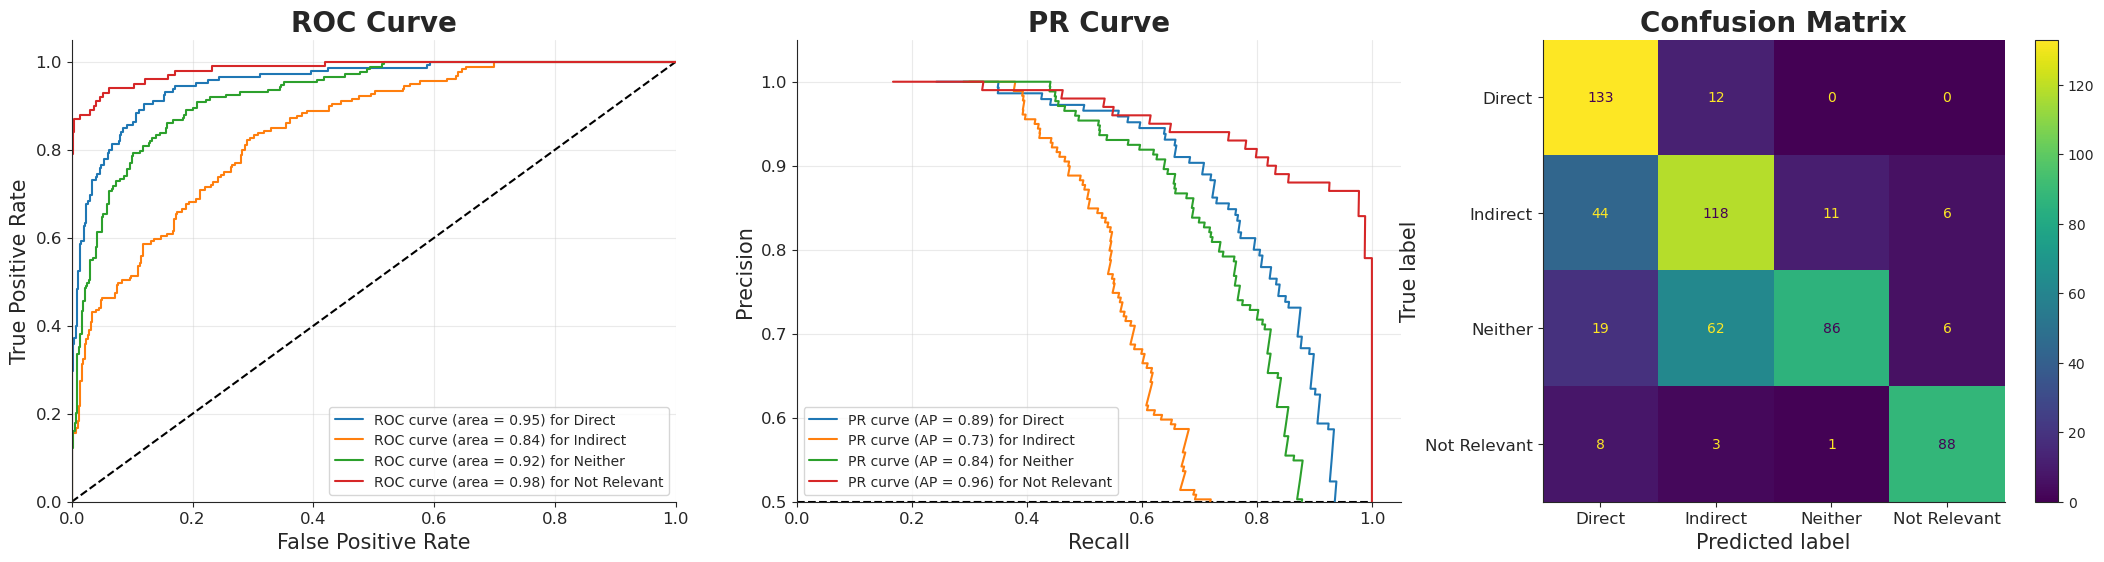

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import seaborn as sns; sns.set_style("ticks")

fig, [ax_roc, ax_pr, conf] = plt.subplots(1, 3, figsize=(26.5, 6))
# fig.tight_layout()


plot_multiclass_roc_from_preds(pred_df['y_true'], pred_df[['Direct', "Indirect", "Neither", "Not Relevant"]].values, 
                               ax=ax_roc,
                               labels=['Direct', "Indirect", "Neither", "Not Relevant"])

for item in (ax_roc.get_xticklabels() + ax_roc.get_yticklabels()):
    item.set_fontsize(12)

ax_roc.title.set_fontsize(20)
ax_roc.title.set_fontweight("bold")
ax_roc.xaxis.label.set_fontsize(15)
ax_roc.yaxis.label.set_fontsize(15)

plot_multiclass_pr_from_preds(pred_df['y_true'], pred_df[['Direct', "Indirect", "Neither", "Not Relevant"]].values, 
                               ax=ax_pr,
                               labels=['Direct', "Indirect", "Neither", "Not Relevant"])

for item in (ax_pr.get_xticklabels() + ax_pr.get_yticklabels()):
    item.set_fontsize(12)

ax_pr.title.set_fontsize(20)
ax_pr.title.set_fontweight("bold")
ax_pr.xaxis.label.set_fontsize(15)
ax_pr.yaxis.label.set_fontsize(15)


    
ConfusionMatrixDisplay.from_predictions(pred_df['y_true'],  pred_df['y_pred'], 
                                        ax=conf, 
                                        display_labels=['Direct', "Indirect", "Neither", "Not Relevant"])

for item in (conf.get_xticklabels() + conf.get_yticklabels()):
    item.set_fontsize(12)

conf.set_title("Confusion Matrix", fontsize=20, fontweight="bold")
# conf.title.set_fontsize(20)
# conf.title.set_fontweight("bold")
conf.xaxis.label.set_fontsize(15)
conf.yaxis.label.set_fontsize(15)


plt.savefig("n2c2_curves_final.png", dpi=600)
# RocCurveDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_roc,)# name=name)
# DetCurveDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_det)#, name=name)
# PrecisionRecallDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_pr)


In [ ]:
import sklearn
# import seaborn as sns; sns.set_style("ticks")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay


In [ ]:
plot_multiclass_roc_from_preds(nlp_df['y_true'], nlp_df[['COND','HARD' ,'NO']].values, labels=["CONDITIONAL", "HARD", "NO"])



# Extras

In [ ]:
# import ast
# def custom_tokenizer(s, return_offsets_mapping=True):
#     # dic = ast.literal_eval(s)
#     print("----")
#     print(s)
#     print("----")
#     if s.strip() > 1:
#         return tokenizer(s.split("</s>"), 
#                          return_offsets_mapping=return_offsets_mapping,
#                                           # truncation="only_second",
#                                           truncation=True,
#                                           max_length=512)
#     else:
#         return tokenizer(s, 
#                                  return_offsets_mapping=return_offsets_mapping,
#                                                   # truncation="only_second",
#                                                   truncation=True,
#                                                   max_length=512)        

In [ ]:
# from transformers import TextClassificationPipeline

# class MyPipeline(TextClassificationPipeline):
#     def preprocess(self, inputs, truncation="only_second",max_length=512, **tokenizer_kwargs):
#         '''inputs here is only one example!!
#         '''
#         return_tensors = self.framework
#         # print(inputs)
#         # print("\n------------------\n")
#         # if isinstance(inputs, dict):
#         #     return self.tokenizer(**inputs, return_tensors=return_tensors, 
#         #                           # truncation="only_second",
#         #                           truncation=True,
#         #                           max_length=512, 
#         #                           **tokenizer_kwargs)
#         # elif isinstance(inputs, list) and len(inputs) == 1 and isinstance(inputs[0], list) and len(inputs[0]) == 2:
#         #     # It used to be valid to use a list of list of list for text pairs, keeping this path for BC
#         #     return self.tokenizer(
#         #         text=inputs[0][0], text_pair=inputs[0][1], return_tensors=return_tensors,truncation=True,max_length=512,
#         #         **tokenizer_kwargs
#         #     )
#         # elif isinstance(inputs, list):
#         #     # This is likely an invalid usage of the pipeline attempting to pass text pairs.
#         #     raise ValueError(
#         #         "The pipeline received invalid inputs, if you are trying to send text pairs, you can try to send a"
#         #         ' dictionnary `{"text": "My text", "text_pair": "My pair"}` in order to send a text pair.'
#         #     )
#         return self.tokenizer(inputs, return_tensors=return_tensors,
#                               truncation=True,
#                               max_length=512,
#                               **tokenizer_kwargs)


In [ ]:
# pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, top_k=None)